# CCSS Web Scraping in Python Spring 2023

The first module will introduce the fundamentals of web scraping in Python by highlighting the Beautiful Soup library. The second module will explore how to navigate dynamically generated website content through interactive scraping powered by Selenium.

We'll be using WebScraper.io's [webscraping test site](https://webscraper.io/test-sites/e-commerce/static) structured as an electronics e-commerce site throughout the exercises. This webpage serves as a great testing ground to learn about web scraping without having to worry about site blockages when building our initial scraper. We'll be toggling back and forth between this notebook and the website to use its Inspect feature to learn more about the site's underlying structure throughout the demos. 


#Module 1- Fundamentals with Beautiful Soup 

Let's start by importing in the libraries we'll be using within the first module: 

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
import pandas as pd
import pprint


Our initial goal will be to retrieve the name, price, description, and number of reviews of the three electronics featured on the site home page. `urllib.requests` is a library that goes hand-in-hand with Beautiful Soup by establishing the HTTP connection we'll need with the e-commerce site to parse the site's HTML. Let's start by inspecting the full HTML of the site itself by directly using the `BeautifulSoup` method with a designated `html.parser`:

In [ ]:
html = urlopen('https://webscraper.io/test-sites/e-commerce/static')
bs_html = BeautifulSoup(html, 'html.parser')
print(bs_html)

### HTML Tags & Attributes

- **Tags** are used to represent different component types within an HTML file, such as the `<title>`, `<div>` for a designated section within the document, and `<h1>` for the first header. 
- HTML tags usually require a closing tag such as </title> or </div>. Sections in HTML begin and end. 
- HTML tags will often include additional information within the tag itself that are known as **attributes**. You can think of attributes as an additional identifier for a given tag.
- Attributes are marked by key words such as `class`, `id`, or `href` (referring to hyperlinks) followed by an equal sign and a label such as `<div class='container'>`

Here are two external references for learning more about the available [tags](https://www.w3schools.com/tags/default.asp) and [attributes](https://www.w3schools.com/tags/ref_attributes.asp) within HTML. 


Our created Beautiful Soup parsed HTML object offers a variety of methods that allows us to look at specific tags within the HTML. The following retrieves the first specified instance of the `<p>` paragraph tag in the HTML file:

In [ ]:
print(bs_html.p)

In [ ]:
#find option pulls the first occurence.
name = bs_html.find('h4')
print(name)

#find_all includes all tags. 
names = bs_html.find_all('h4')
print(names)

Attributes are used to distinguish different subgroups of the same base HTML tag. This facilitates the easy retrieval of distinct HTML elements within a web scraping program that we would otherwise struggle to differentiate due to having the same tags. An example of this is the e-commerce test site `<div class="caption">` and `<div class="ratings">` to distinguish between the product descriptions and the ratings of the items being displayed on the website. 

We can use the `find_all` method to identify any of the `div` tags with their `class` attribute specified as a `caption` as follows:

In [ ]:
bs_html.find_all('div', {'class':'caption'})

The `get_text` method strips away the HTML tags to just express the text itself:

In [ ]:
captions = bs_html.find_all('div', {'class':'caption'})
for name in captions:
    print(name.get_text())

The basic workflow behind using Beautiful Soups' `find` and `find_all` methods is to first specify the tag you're interested in within the HTML document, and then the associated attributes that further narrows your search from the tag. 

We can build from this to retrieve multiple tag types at once, such as all of the headers set to the 1, 2, and 4 subheader sizes as follows:  

In [ ]:
bs_html.find_all(['h1','h2','h4'])

Can pull parent attributes to better extract text. 1 level up from what we initially select. Can be used for targeting specific information in a container, then targeting the entire container through parent. 

In [ ]:
#Parent attribute. 1 tag up. Want h4 class pull right price. 
price = bs_html.find_all('h4', {'class':'pull-right price'})
print(price)
#Now go up a level to get the section with all those details. Store inside another object
section = []
for item in price:
    section.append(item.parent)

print(section)

We can also identify multiple attribute matches to the same tag in a single `find_all` call. We achieve this by setting our second parameter as a dictionary with the `class` attribute as the key as the attribute labels `caption` and `ratings` as values. Another way to extract what we did above.

In [ ]:
caption_reviews = bs_html.find_all('div', {'class':{'caption', 'ratings'}})
for name in caption_reviews:
    print(name.get_text())

If you look closely, you'll notice how the values for the electronic goods returned from Beautiful Soup don't actually align with what you currently see when looking at the site directly via Inspect. The site is updating the items shown on the homepage outside of default values set within the HTML. 

### Saving Scraped Data 

After identifying the tags and attributes that will allow us to match with the specific data we're interested in collecting from the website's HTML, we'd then proceed with the actual data collection within our scraper. The `pandas` library naturally intergrates with Beautiful Soup HTML parsing by structuring different tag retrievals into designated data columns. 

Let's build up to creating a function that retrieves the product data we're interested in via the e-commerce site's URL and stores it within a pandas DataFrame for us. We can envision creating columns that separate out the title, description, price, and reviews of each of the products on the site's home page.

(Check out [CCSS' workshop on pandas](https://github.com/ccss-rs/python-bootcamp/blob/main/pandas.ipynb) on your own if you haven't worked with Pandas before or need a refresher.)  

A helpful strategy that moves us closer to our goal of producing a final data frame is using a different Beautiful Soup pattern matching of the HTML tag that has the data we're interested in with the tag's unique attributes and passing the text of all matches into a list through list comprehension statements. 

Here's an example for the `a` tag distinguished by the `class` attribute labeled as `title`:

As we're building up to a function that will represent our web scraped data into a row and column format that will be ideal for final data storage on our local computer, it's often helpful to think through what data types can be handled by pandas that effectively matches column names (title, description, price, and reviews) to rows representing each scraped product. 

A go-to is dictionaries since the key-value structure naturally translates to a column-row format within pandas. We'll therefore create a dictionary to hold our scraped data from Beautiful Soup as follows: 

In [ ]:
title = [values.get_text() for values in bs_html.find_all('a', {'class': 'title'})]
links = [values['href'] for values in bs_html.find_all('a', {'class': 'title'})]
desc = [values.get_text() for values in bs_html.find_all('p', {'class': 'description'})]
price = [values.get_text() for values in bs_html.find_all('h4', {'class': 'pull-right price'})]
reviews = [values.get_text() for values in bs_html.find_all('p', {'class': 'pull-right'})]

#Create pandas dataframe.
data = pd.DataFrame({
    'title': title,
    'price': price,
    'url': links,
    'description': desc,
    'reviews': reviews
})
display(data)

Now that we have the individual components thought through regarding how to automate collecting data from the website in a format ideal to create a final pandas data frame with, we're ready to combine these steps into one function that will run through the entire process for us and return the data frame as its output. 

`html_to_pandas` achieves this for us: 

In [ ]:
def extract(url):
    # Establish our connection to the website and create a Beautiful Soup object
    html = urlopen(url)
    bs_html = BeautifulSoup(html, 'html.parser')
    #Extract desired contents
    title = [values.get_text() for values in bs_html.find_all('a', {'class': 'title'})]
    links = [values['href'] for values in bs_html.find_all('a', {'class': 'title'})]
    desc = [values.get_text() for values in bs_html.find_all('p', {'class': 'description'})]
    price = [values.get_text() for values in bs_html.find_all('h4', {'class': 'pull-right price'})]
    reviews = [values.get_text() for values in bs_html.find_all('p', {'class': 'pull-right'})]
    
    #Place into data frame
    data = pd.DataFrame({
    'title': title,
    'price': price,
    'url': links,
    'description': desc,
    'reviews': reviews
    })
    
    #Output dataframe
    return data

In [ ]:
data = extract('https://webscraper.io/test-sites/e-commerce/static')
display(data)

We've successfully gone from a whole jumble of HTML and website text to a ordered DataFrame with the exact information we're interested in via Beautiful Soup. In an actual web scraping data collection workflow you'd likely save the above data frame to your personal computer such as via a CSV file. 

#Regular Expression:
We can search a website for specific text or characters. Something like a dollar sign before price.

In [ ]:
import re
#Can search page for specific text. Used best with regular expression. 
#Find all text after dollar sign $. '\$' find dollar sign. '.*' get any text after
price = bs_html.find_all(text=re.compile("\$.*"))
print(price)

# Addendum- Regular Expressions (Regexes)
While we retrieved all of the product prices through identifying headers specified as members of the 'pull-right price' class attribute through Beautiful Soup as follows:

In [ ]:
bs_html.find_all('h4', {'class': 'pull-right price'})

Let's say we were instead in a situation where the prices weren't clearly distinguished to belong to a specific class attribute. 
We can an use regular expressions (**regexes**) to identify variable text that has some degree of consistency with its formatting
such as all of the numbers that follow from the '$' symbol.

Regexes are particularly helpful for identifying data such as emails, phone numbers, dates, or specific file types such as '.pdf' or '.jpg'. Although a complex topic on their own right that's beyond the scope of this workshop, they're very commonly used within web scraping projects and therefore important to familirize ourselves with. 

I highly recommend test running any code you write that uses regexes while developing your scraper to think through edge cases in the data that a current regex version may miss. I personally use [Regex 101](https://regex101.com/) as a website to check the behavior of regexes whenever I'm using them within my own work.  

We can use Python's built-in `re` library to combine regexes with Beautiful Soup. A regex that will successfully identify all instances of prices specified in dollars is `"\$\d+(?:\.\d+)?"`. Regex syntax is convoluted, which is partially why they can be challenging to structure correctly. Let's break down what the individual components of this regex is achieving for us:
- `\$` starts the match based on the dollar sign symbol as our core anchor to find the product prices.
- `\d+` will match with one or more digits that follow the dollar sign.
- `(?:\.\d+)?` specifies an optional decimal value and any digits that follows the decimals. This structure effectively handles cases where the price is listed either with or without decimal points.

In [ ]:
bs_html.find_all(string=re.compile("\$\d+(?:\.\d+)?"))

##BS4 Exercise
Goal: Extract job title, job link, brief description provided. 
Bonus: Place in Pandas dataframe and print
Website URL : https://realpython.github.io/fake-jobs/

Another practice website: https://realpython.github.io/fake-jobs/

# Module 2- Dynamic Sites with Selenium 
The first module of the coding demo provided an overview regarding how web scraping programs are fundamentally a process of identifying how data is represented within site HTML and retrieving said information through libraries such as Beautiful Soup. Through the Beautiful Soup library, we were limited in our ability to guide our scraper through the site's content beyond what we initially see.

This is a very common situation individuals interested in building web scrapers find themselves in, and is why we'll therefore bring in Selenium as our next core tool to automate our site interactions. Throughout this module we'll be exploring how to properly initiatilize a Selenium web driver browser session, how to find HTML elements within the site with Selenium's particular methods, how to interact with site content through implementing wait times and addressing site exceptions, and how to piece all of these components together to obtain a final data set of product records collected over multiple web pages. 

We'll need to `pip install selenium` directly since it doesn't come pre-installed in our Google Colab virtual Python environment, as well as download and install the [Chrome Web Driver](https://chromedriver.chromium.org/home) that we'll be using to run our own Chrome browser through Selenium into a local directory path our program will have access to.

In [ ]:
!pip install -q selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver/usr/bin

We'll use the `sys` library to explicitly set the Chrome driver's location as well as import in a suite of methods from Selenium we'll be using to build our scraper. 

In [ ]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

import re
import pandas as pd

Let's create a designated `Options` instance to configure our Chrome driver. Selenium won't actually run within Google Colab unless the browser is set to `--headless`, while the additional options are designed to optimize resource use and prevent browser crashes. If doing on personal computer and do not include headless option, you can see your browser open and process in live time. Can be useful when practicing to see it function in live time. Also to diagnose errors where you are getting stuck. 

In [ ]:
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

We'll then instantiate our Selenium-driven Chrome web browser by referring to the chromedriver executable package we've downloaded into our local directory, pass our set option parameters, and then connect to the URL of the e-commerce webscraping test site. This time we'll be collecting product information specific to the [touch phone sublisting](https://www.webscraper.io/test-sites/e-commerce/static/phones/touch?page=1) of the site, as the page features the dynamic component of having multiple pages of listed products that we toggle through by clicking on page buttons. 

In [ ]:
driver = webdriver.Chrome('chromedriver', options=options)
url = 'https://www.webscraper.io/test-sites/e-commerce/static/phones/touch?page=1'
driver.get(url)

### Finding Elements 

Selenium offers a range of methods to locate elements within the website's HTML. Beautiful Soup's strategy to identify specific data was through the `find` and `find_all` methods, while Selenium's equivalent is based upon the combination of the `find_elements` method of our web driver with a designated parameter set via the `By` locater class. 

Here's a visual reference of how these two libraries compare to each other in syntax to achieve the same goal:

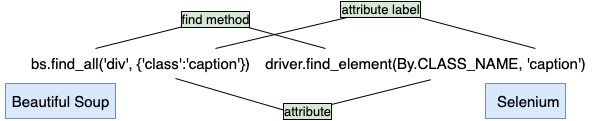

We can retrieve all of the elements on the web page with a specified class value of `caption` within the `div` HTML tag as follows: 

In [ ]:
for vals in driver.find_elements(By.CLASS_NAME, 'caption'):
    print(vals.text)

### Interacting with Elements 

The above example is only collecting the data of the first page of the site that features 6 phones, but there's actually a second page that has an additional 3 phones listed that you can access by clicking either the 2 or next arrow button on the website. This is the exact circumstance we've turned to Selenium to handle for us to coordinate clicking said buttons via our headless Chrome browser.

We can use the `page-link` class name to identify the button selection options found within the HTML: 

In [ ]:
for vals in driver.find_elements(By.CLASS_NAME, 'page-link'):
    print(vals.text)

The most robust technique for building our scraper would be clicking on the 'Next' button rather than '2', since that'll allow us to replicate our code for pages on the website with more than 2 pages worth of listed products. 

Specifically referencing the `rel="next"` relationship parameter that distinguishes the "next" button is a great use case for an XPath locator:
More on XPath at the bottom of the document.  

In [ ]:
driver.find_element(By.XPATH, "//a[@rel='next']").text

Now that we've found a way to identify the particular button we're interested in, it's an intuitive Selenium method to actually faciliate a user click through our headless browser. Quick heads up- you're intentionally about to see an error!

In [ ]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

We're encountering an unexpected raised exception here, which is liable to occur
whenever an interaction with a website via Selenium doesn't achieve the behavior the code developer was likely aiming to create. Exception messages are often quite informative towards identifying the underlying issue. The `ElemenentClickInterceptedException` refers to there being an "Other element would receive the click", and then references an `acceptContainer` div class attribute that's also within the website's HTML structure. 

If we switch over to the website's Inspect tab and identify what exactly the `acceptContainer` is on the website itself, we see it's equivalent to the "We use cookies to make your Web Scraper experience better" pop-up that appears at the bottom of the site the first time you visit the page. 

Although it's easy enough for us to ignore the pop-up and click on other components of the site as manual users, the pop-up is intercepting our attempted click on the next arrow button when we try to interact with the site via Selenium. The issue is simply resolved by the following:

In [ ]:
driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

In [ ]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

This is a great example of a common situation with building scrapers for dynamic sites, in that you often can't tell what may raise issues within your code until you're actually testing with a web driver.

What happen if we were to click the "next" button a second time? Remember that we only have two pages worth of listed phones, so we're about to see a different type of exception come up: 

In [ ]:
driver.find_element(By.XPATH, "//a[@rel='next']").click()

The raised `NoSuchElementException` implies that our program doesn't think that the next arrow button exists. If you dig into the HTML on the website itself via Inspect following clicking the next arrow button, you can see that the website updates to list the button as a member of the class attibute `"page-item disabled"` subtree within the pagination container of the site. This means that the site is recognizing that there are no more pages to click the next arrow following one click to the second page. 

Receiving this error reasserts for us that our Selenium-powered web driver session is indeed similar to us manually interacting with the site itself, as our past behaviors during our entire scraping workflow dictate how the website changes and therefore how we should adapt our code to accomadate the new site structure. 

We can therefore adjust by prompting our program to click the previous arrow button instead, which has switched from `"page-item disabled"` class status to now a live page link after we guided our driver to move from the first to second page: 

In [ ]:
driver.find_element(By.XPATH, "//a[@rel='prev']").click()

This puts us back to where we started on the first page of the listed phones for sale. 

### Automating Multi-Page Data Collection 

Now that we've covered how to interact directly with the site through clicking elements as well as a few common complications within the click-through process to keep an eye out for, we're ready to move towards using our program to properly time the transitions between site interactions, website updates, and then correctly identifying newly displayed data.  

First, it's generally a good idea to reinitialize our web driver when automating a full workflow of data collection with Selenium to give us a clean slate without worrying about errors coming up around our previous interactions: 

In [ ]:
# Create a new web driver connection to the site 
driver = webdriver.Chrome('chromedriver', options=options)
driver.get(url)

# Click the cookie pop-up so we don't raise a ElementClickInterceptedException
driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

We'll want to now think through how we'll collect and store data across the pages. Let's start with a simple list that holds the product titles on the first page: 

In [ ]:
# Create a list to hold collected product titles
element_list = []

# Collect the product titles on the first page 
for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
    element_list.append(vals.text)

# Otherwise could do the following. Same thing. 
element_list1 = []

for vals in driver.find_elements(By.CLASS_NAME, "title"):
    element_list1.append(vals.text)

print(element_list1)
print(element_list)

['Nokia 123', 'LG Optimus', 'Samsung Galaxy', 'Nokia X', 'Sony Xperia', 'Ubuntu Edge']
['Nokia 123', 'LG Optimus', 'Samsung Galaxy', 'Nokia X', 'Sony Xperia', 'Ubuntu Edge']


We can see that we've gathered the product titles of the six items on the first page, so we're now ready to move forward to the second page by clicking on the next arrow: 

In [ ]:
# Click the next arrow to the second page 
driver.find_element(By.XPATH, "//a[@rel='next']").click()

This is all well and good for our interactive Colab session, but in a full-fledge automated function for web scraping, we're missing one key component still in successfully designing our data collection of the product titles to handle interacting with the two pages through button clicks. 

### Waits


Waits, website element checks, and managing exceptions go hand-in-hand with each other. By implementing waits, we avoid errors in our scraper by allotting the time needed for the website to properly update. Selenium offers two types of waits which we'll both consider towards the goal of retrieving all of the phone names on the e-commerce site across both of the pages. 

**Implicit waits** sets a designated amount of time that the web driver will pause for. They're designed to broadly estimate how long a website will take to update following clicking on a page. 

The following function combines multiple of our previous steps within the module to collect the phone names from the first page of the site, click on the cookie pop-up and next arrow button, use a 5-second wait to give the site time to update following the next arrow click, and then print out all 9 phone names that we're expecting across the two pages.


In [ ]:
def implicit_wait(url): 
    # Create a new web driver connection to the site 
    driver = webdriver.Chrome('chromedriver', options=options)
    driver.get(url)

    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    element_list = []

    # Collect the product titles on the first page 
    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)
    
    # Click the next arrow to the second page 
    driver.find_element(By.XPATH, "//a[@rel='next']").click()

    # IMPLICIT WAIT for 5 seconds 
    driver.implicitly_wait(5)

    # Collect the product titles on the second page 
    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    # Print out the results stored within the list
    return print(*element_list, sep='\n')

implicit_wait(url)

Nokia 123
LG Optimus
Samsung Galaxy
Nokia X
Sony Xperia
Ubuntu Edge
Iphone
Iphone
Iphone


Success! While implicit waits are a solid technique and certainly important to be familiar with when using Selenium, I'd overall recommend using **explicit waits** over implicit waits when given the option between the two. Explicit waits employ both the specified pause time of implicit waits with the additional feature of designating conditions that Selenium will check whether they become satisfied after interacting with the web site. It therefore provides more information regarding what you're expecting to occur following interacting with the page beyond just placing a brief wait without any additional context. 

Explicit waits are conducted via the `WebDriverWait` class in combination with `expected_conditions` (commonly shortened to `EC`). The one-line adaption of our implicit wait code block via the `explicit_wait` function that follows below designates what the browser will need to locate before proceeding forward with collecting data from the second page. 

`EC.presence_of_element_located` specifies our web driver to pause until the titles of the phones on the second page are displayed on the website. The number you pass along with `WebDriverWait` sets the amount of time before raising an exception similar to implicit waits, but this time it's based on whether the expected condition is met within the updated website HTML. I often use `EC.element_to_be_clickable` as well to ensure that a new element is fully loaded for interaction as my expected condition parameter, while many more conditions are available [as listed here](https://selenium-python.readthedocs.io/api.html#module-selenium.webdriver.support.expected_conditions). 

In [ ]:
# This function is exactly the same as above except for the use of an explicit 
# wait instead of an implicit wait

def explicit_wait(url): 
    driver = webdriver.Chrome('chromedriver', options=options)
    driver.get(url)

    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    element_list = []

    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    driver.find_element(By.XPATH, "//a[@rel='next']").click()

    # EXPLICIT WAIT based on the new titles being uploaded 
    WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH , "//a[@class='title']")))

    for vals in driver.find_elements(By.XPATH, "//a[@class='title']"):
        element_list.append(vals.text)

    return print(*element_list, sep='\n')

explicit_wait(url)

Nokia 123
LG Optimus
Samsung Galaxy
Nokia X
Sony Xperia
Ubuntu Edge
Iphone
Iphone
Iphone


### Combining into a Pandas DataFrame

Let's finish by combining all of the core ideas we've covered to collect the prices, titles, descriptions, and number of reviews of all of the phones on the two pages of the e-commerce site. We'll know that we've succeeded if we obtain a DataFrame with 9 unique records as that's the total count of unique items listed across the two pages. 

The following `phone_dataframe` function merges all of our previously covered topics into one code block. We first initiatize our web driver, connect to the e-commerce site URL, and take care of the cookie pop-up that would otherwise conflict with our page button clicks. We additionally create a data list to collect the record values for each product. 

The `pages_left` variable is designed to serve as a stopping condition so Selenium will know when we've reached the last page and it can therefore break out of the data collection portion of the function. The complete workflow of data collection is based on the condition of `pages_left` exisiting, where for each round of data scraping we subsequently reduce the value by one. The idea behind this approach is that you can change `pages_left` to represent the number of pages you'd like to collect data from as needed. 

The text associated with the `thumbnail` class parameter in the HTML contains the exact four data points for each record that we're interested in, so we use an XPath based on identifying the `thumbnail` attribute as our element finder. 

You'll also note that our clicking of the next arrow button and then explicit wait is conditioned on the `pages_left` parameter not being at 1. This is the avoid the raised exception scenario we reviewed earlier regarding the next arrow being disabled by the site once we've reached the last page, which is equivalent to 1 in our `pages_left` condition. 

In [ ]:
def phone_dataframe(url): 
    # Create a new web driver connection to the site 
    driver = webdriver.Chrome('chromedriver', options=options)
    driver.get(url)

    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    data_list = []

    # Set a pages left parameter that we deduct every time we scrape a full page
    pages_left = 2

    # Condition of the loop proceeding while the pages_left parameter isn't 0
    while pages_left: 

        # Collect the price, title, description, and reviews on the first page 
        for vals in driver.find_elements(By.XPATH, "//div[@class='thumbnail']"):
            vals = re.split(r'\n', vals.text)
            data_list.append(vals)
        
        # Click to the next page if we're not on the last page 
        if pages_left != 1: 
            driver.find_element(By.XPATH, "//a[@rel='next']").click()
        
        # Explicitly wait for the page navigation buttons to be clickable again
        # following our previous click 
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH , "//a[@rel='prev']")))

        # Deduct our pages left stopping condition by 1 at the end of the loop
        pages_left -= 1

    # Once we've broken out of our while loop, transform our data storage list
    # into a pandas data frame 
    phone_df = pd.DataFrame(data_list)

    # Set our data column labels 
    phone_df.columns = ['Price', 'Title', 'Description', 'Reviews']

    # Return our data frame 
    return phone_df

In [ ]:
phone_df = phone_dataframe(url)
phone_df

,Price,Title,Description,Reviews
0,$24.99,Nokia 123,7 day battery,11 reviews
1,$57.99,LG Optimus,"3.2"" screen",11 reviews
2,$93.99,Samsung Galaxy,5 mpx. Android 5.0,3 reviews
3,$109.99,Nokia X,"Andoid, Jolla dualboot",4 reviews
4,$118.99,Sony Xperia,"GPS, waterproof",6 reviews
5,$499.99,Ubuntu Edge,Sapphire glass,2 reviews
6,$899.99,Iphone,White,10 reviews
7,$899.99,Iphone,Silver,8 reviews
8,$899.99,Iphone,Black,1 reviews


Now instead of hard coding the 2. Use program to identify what the last page is. Then set that so you do not have to edit program when there are different page numbers. 

In [ ]:
 def phone_dataframe(url):    
    driver = webdriver.Chrome('chromedriver', options=options)
    driver.get(url)

    # Click the cookie pop-up so we don't raise a ElementClickInterceptedException
    driver.find_element(By.CLASS_NAME, 'acceptContainer').click()

    # Create a list to hold collected product titles
    data_list = []
    page_list = []
    pages_total = driver.find_elements(By.CLASS_NAME, "page-link")
    end = pages_total[len(pages_total) - 2].text
    end = int(end)

    # Set a pages left parameter that we deduct every time we scrape a full page
    pages_left = end

    # Condition of the loop proceeding while the pages_left parameter isn't 0
    while pages_left: 

        # Collect the price, title, description, and reviews on the first page 
        for vals in driver.find_elements(By.XPATH, "//div[@class='thumbnail']"):
            vals = re.split(r'\n', vals.text)
            data_list.append(vals)
        
        # Click to the next page if we're not on the last page 
        if pages_left != 1: 
            driver.find_element(By.XPATH, "//a[@rel='next']").click()
        
        # Explicitly wait for the page navigation buttons to be clickable again
        # following our previous click 
        WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH , "//a[@rel='prev']")))

        # Deduct our pages left stopping condition by 1 at the end of the loop
        pages_left -= 1

    # Once we've broken out of our while loop, transform our data storage list
    # into a pandas data frame 
    phone_df = pd.DataFrame(data_list)

    # Set our data column labels 
    phone_df.columns = ['Price', 'Title', 'Description', 'Reviews']

    # Return our data frame 
    return phone_df

In [ ]:
phone_df = phone_dataframe(url)
phone_df

,Price,Title,Description,Reviews
0,$24.99,Nokia 123,7 day battery,11 reviews
1,$57.99,LG Optimus,"3.2"" screen",11 reviews
2,$93.99,Samsung Galaxy,5 mpx. Android 5.0,3 reviews
3,$109.99,Nokia X,"Andoid, Jolla dualboot",4 reviews
4,$118.99,Sony Xperia,"GPS, waterproof",6 reviews
5,$499.99,Ubuntu Edge,Sapphire glass,2 reviews
6,$899.99,Iphone,White,10 reviews
7,$899.99,Iphone,Silver,8 reviews
8,$899.99,Iphone,Black,1 reviews


We can see that our final DataFrame does indeed feature 9 records, confirming that our complete function successfully handled clicking through multiple pages worth of product listings. 

Congratulations on completing the second module of our webscraping coding demos! We started with the very basics of connecting to a website and inspecting HTML code and advanced all the way to interacting directly with the site to retrieve dynamically generated data. Let's now return to the slides to conclude our web scraping workshop. 

# Addendum- Regular Expressions (Regexes)
While we retrieved all of the product prices through identifying headers specified as members of the 'pull-right price' class attribute through Beautiful Soup as follows:

In [ ]:
bs_html.find_all('h4', {'class': 'pull-right price'})

[<h4 class="pull-right price">$1149.73</h4>,
 <h4 class="pull-right price">$1112.91</h4>,
 <h4 class="pull-right price">$1140.62</h4>]

Let's say we were instead in a situation where the prices weren't clearly distinguished to belong to a specific class attribute. 
We can an use regular expressions (**regexes**) to identify variable text that has some degree of consistency with its formatting
such as all of the numbers that follow from the '$' symbol.

Regexes are particularly helpful for identifying data such as emails, phone numbers, dates, or specific file types such as '.pdf' or '.jpg'. Although a complex topic on their own right that's beyond the scope of this workshop, they're very commonly used within web scraping projects and therefore important to familirize ourselves with. 

I highly recommend test running any code you write that uses regexes while developing your scraper to think through edge cases in the data that a current regex version may miss. I personally use [Regex 101](https://regex101.com/) as a website to check the behavior of regexes whenever I'm using them within my own work.  

We can use Python's built-in `re` library to combine regexes with Beautiful Soup. A regex that will successfully identify all instances of prices specified in dollars is `"\$\d+(?:\.\d+)?"`. Regex syntax is convoluted, which is partially why they can be challenging to structure correctly. Let's break down what the individual components of this regex is achieving for us:
- `\$` starts the match based on the dollar sign symbol as our core anchor to find the product prices.
- `\d+` will match with one or more digits that follow the dollar sign.
- `(?:\.\d+)?` specifies an optional decimal value and any digits that follows the decimals. This structure effectively handles cases where the price is listed either with or without decimal points.

In [ ]:
bs_html.find_all(string=re.compile("\$\d+(?:\.\d+)?"))

#Addendum XPATH
There are many different attributes we can combine with `By` to find elements, such as `ID`, `NAME`, and `TAG_NAME`. [Here's a helpful guide](https://selenium-python.readthedocs.io/locating-elements.html) that reviews the avaliable options and example HTML.  

A location method that's particularly important to highlight is Selenium's support of **XPath** locators. The XPath language is similar to regexes which you can learn more about in the addendum at the bottom of this notebook. XPaths are designed to navigate HTML documents to the greatest degree of customization regarding what you'd like to match.They're particularly helpful when you don't have an easy class or id attribute to retrieve the element you're interested in.  

The equivalent XPath syntax to retrieve the exact same information we obtained from the product captions by matching with their class name is:

In [ ]:
# Create a new web driver connection to the site 
driver = webdriver.Chrome('chromedriver', options=options)
driver.get(url)

# Click the cookie pop-up so we don't raise a ElementClickInterceptedException
driver.find_element(By.CLASS_NAME, 'acceptContainer').click()
for vals in driver.find_elements(By.XPATH, "//div[@class='caption']"):
    print(vals.text)